### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import pandas as pd

# File to Load (Remember to Change These)
file_to_load = "Resources/purchase_data.csv"

# Read Purchasing File and store into Pandas data frame
purchase_data = pd.read_csv(file_to_load)

In [2]:
#This is a function to format and return currency columns transiently, so I can still perform computation upon them later on.
def fancify(dataframe, column_list):
    temp_frame = dataframe.copy()
    for item in column_list:
        temp_frame[item] = temp_frame[item].apply(lambda x: f"${x:.2f}")
    return temp_frame

## Player Count

* Display the total number of players


In [3]:
purchase_data.head()

,Purchase ID,SN,Age,Gender,Item ID,Item Name,Price
0,0,Lisim78,20,Male,108,"Extraction, Quickblade Of Trembling Hands",3.53
1,1,Lisovynya38,40,Male,143,Frenzied Scimitar,1.56
2,2,Ithergue48,24,Male,92,Final Critic,4.88
3,3,Chamassasya86,24,Male,100,Blindscythe,3.27
4,4,Iskosia90,23,Male,131,Fury,1.44


In [4]:
purchase_summary = pd.DataFrame(data = {"Total Players":
                                       purchase_data['SN'].unique().shape[0]},
                               index = [0])
purchase_summary

,Total Players
0,576


## Purchasing Analysis (Total)

* Run basic calculations to obtain number of unique items, average price, etc.


* Create a summary data frame to hold the results


* Optional: give the displayed data cleaner formatting


* Display the summary data frame


In [5]:
#Calculate the 4 items that should be housed in the Purchasing Analysis Table.
items_unique = purchase_data['Item ID'].unique().shape[0]
average_price = purchase_data['Price'].mean()
number_of_purchases = purchase_data.shape[0]
total_revenue = purchase_data['Price'].sum()
#Now I format it into a dictionary, with some formatting done to the currency values.
purch_analysis_dict = {
    "Number of Unique Items": items_unique,
    "Average Price": f"${round(average_price, 2)}",
    "Number of Purchases": number_of_purchases,
    "Total Revenue": f"${total_revenue}"
}

In [6]:
purchasing_analysis = pd.DataFrame(data = purch_analysis_dict, index=[0])
purchasing_analysis

,Number of Unique Items,Average Price,Number of Purchases,Total Revenue
0,179,$3.05,780,$2379.77


## Gender Demographics

* Percentage and Count of Male Players


* Percentage and Count of Female Players


* Percentage and Count of Other / Non-Disclosed




In [7]:
#Establish base counts for the players
gender_counts = purchase_data.drop_duplicates(subset="SN").groupby("Gender").count()

In [8]:
#Format these counts into a single table
#In order to do this, I grab all the values from one of the columns in my counted gender groups.
#Then I set the index for my new table by taking the index for the old one. I access this using reset_index.
gender_demographics = pd.DataFrame(data = {
    "Total Count": gender_counts['SN']
}, index=gender_counts.reset_index()['Gender'])

In [9]:
#Now add the percentages to the table. 
#At its core, we are just dividing each count by the sum of all unique players. 
#Then, to format it, we round the data. 
#Finally, we use apply take each value, and return an f string which adds a % sign to it.
gender_demographics['Percentage of Players'] = round(gender_demographics['Total Count']/gender_demographics['Total Count'].sum()*100, 2).apply(lambda x: f"{x}%")

In [10]:
gender_demographics

,Total Count,Percentage of Players
Gender,,
Female,81,14.06%
Male,484,84.03%
Other / Non-Disclosed,11,1.91%



## Purchasing Analysis (Gender)

* Run basic calculations to obtain purchase count, avg. purchase price, avg. purchase total per person etc. by gender




* Create a summary data frame to hold the results


* Optional: give the displayed data cleaner formatting


* Display the summary data frame

In [11]:
#Create a new groupby gender that can have many functions called upon it.
gender_purchases = purchase_data.groupby('Gender')

In [12]:
#Grab the purchase count by using count on the group by. The column to count does not matter, and was chosen at random.
purchase_count = gender_purchases['SN'].count()
#Calculate the average purchase price
av_price = gender_purchases['Price'].mean()
#Calculate the total amount purchased
total_purchase = gender_purchases['Price'].sum()

In [13]:
#in order to get an avg total per person, I can use the gender split total players from last example.
#Fortunately, since they have the same index, they can be directly computed against each other. 
avg_per_person = total_purchase/gender_demographics['Total Count']

In [14]:
#finally, I create my dataframe. 
#For the currency columns, i use apply to change the series i created earlier into presentational currency strings.
purchasing_analysis_by_gender = pd.DataFrame(data = {
                                                    'Purchase Count': purchase_count,
                                                    'Average Purchase Price': av_price,
                                                    'Total Purchase Value': total_purchase,
                                                    'Average Total Purchase per Person': avg_per_person
                                                    }, index=gender_counts.reset_index()['Gender']
                                            )
fancify(purchasing_analysis_by_gender, ['Average Purchase Price', 'Total Purchase Value', 'Average Total Purchase per Person'])

,Purchase Count,Average Purchase Price,Total Purchase Value,Average Total Purchase per Person
Gender,,,,
Female,113,$3.20,$361.94,$4.47
Male,652,$3.02,$1967.64,$4.07
Other / Non-Disclosed,15,$3.35,$50.19,$4.56


# Gender Behavior Written Analysis

On average, it looks like women spend approximately $0.40 more per person. While that might not seem like a huge amount, it represents females being on average approximately 10% more lucrative.

It could be random variation in our data generating this difference however. In order to determine whether or not this represents a real difference, I will perform a T-Test.

In [15]:
import numpy as np

In [16]:
#first, I will calculate the standard deviation for the average total purchased by females and males.
#In order to do this, I need to have the individuals, grouped by gender.

sum_of_individuals = purchase_data.groupby(['Gender', 'SN']).sum()
#now that I have my dataframe, I can locate the male and female groups independently to calculate summary statistics.
males = sum_of_individuals.loc['Male']
females = sum_of_individuals.loc['Female']
male_deviation = np.std(males['Price'])
female_deviation = np.std(females['Price'])

The First interesting statistic on this journey is our standard deviation. This will let me see how wildly the purchase amounts tend to spread in males and females.

In [17]:
male_deviation

2.387202637384961

In [18]:
female_deviation

2.518431540497606

As we can see, females have a slightly larger spread to their standard deviation, but it is not a huge effect.

Now I can calculate my T statistic! I will do this using the following formula.

![](t-formula.png)

In [19]:
#Reference the previously obtained means in purchasing analysis.
mean_diff = (purchasing_analysis_by_gender.loc['Female', 'Average Total Purchase per Person'] - purchasing_analysis_by_gender.loc['Male', 'Average Total Purchase per Person'])
#Now I will store the female and male deviation squared divided by number of players.
female_dev_squared_over_mean = (female_deviation * female_deviation / gender_demographics.loc['Female', 'Total Count'])
male_dev_squared_over_mean = (male_deviation * male_deviation / gender_demographics.loc['Male', 'Total Count'])

In [20]:
t_value = mean_diff / np.sqrt(female_dev_squared_over_mean + male_dev_squared_over_mean)
t_value
#I also need the degrees of freedom for the population, which is the total population - 2.
degrees_freedom = gender_demographics.loc['Male', 'Total Count'] + gender_demographics.loc['Female', 'Total Count'] - 2

Now that I have calculated a t-value, I need to find out whether it is significant. In order to do so, I am going to have to import stats from SciPy.

In [21]:
import scipy.stats as stats

In [22]:
p_value = 1 - stats.t.cdf(t_value,df=degrees_freedom)
p_value

0.0899326854683955

This value falls above the 0.05 alpha I would normally use in this case, so I do not reject the null hypothesis that the two populations are the same in purchasing behavior.

However, that doesn't mean we should dismiss this trend. Our p value indicates that there is a roughly 90% chance that the current female players are more lucrative on average than the male players. This suggests it may be valuable to investigate more, and even to attempt to promote increased engagement from female audiences to bring the gender distribution closer to even. 

# Gender Behavior Written Analysis - Part 2

While there is a possible trend in female players being more lucrative, we haven't yet asked what differences in behavior drive this profitability.

We can clearly see from the gender purchasing analysis above that females purchase an average item that is worth $.20 more than men. But how do we tell what percentage of the purchasing difference that accounts for? Do women on average purchase more than men?

In [23]:
women_purchasing_rate = (purchasing_analysis_by_gender.loc['Female', 'Purchase Count']
                         / gender_demographics.loc['Female', 'Total Count'])
men_purchasing_rate  = (purchasing_analysis_by_gender.loc['Male', 'Purchase Count']
                         / gender_demographics.loc['Male', 'Total Count'])
f'Women purchase on average {women_purchasing_rate/men_purchasing_rate} items compared to men.'

'Women purchase on average 1.0355979701582974 items compared to men.'

From this, we can see that women on average buy the same number of items as men. Thus, almost all of the bias is based upon women buying more valuable items on average than men. 

## Age Demographics

* Establish bins for ages


* Categorize the existing players using the age bins. Hint: use pd.cut()


* Calculate the numbers and percentages by age group


* Create a summary data frame to hold the results


* Optional: round the percentage column to two decimal points


* Display Age Demographics Table


In [24]:
#Establish an array to slice with
bins = [0, 10, 15, 20, 25, 30, 35, 40, 200]

In [25]:
#Cut and label the data, creating a new categories table in my original dataframe.
purchase_data["Age Categories"] = pd.cut(purchase_data['Age'], bins, right = False, labels = ['<10', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40+'] )
#Create a seperate subset, grouped by Age Categories, with duplicate players dropped.
age_demo = purchase_data.drop_duplicates(subset="SN").groupby('Age Categories').count()["SN"].copy()
#Store this into a new dataframe. 
age_df = pd.DataFrame(data = {'Total Players': age_demo}, index = age_demo.reset_index()['Age Categories'])


In [26]:
#Calculate the percentages by age groups
age_df['Percentage of Players'] = (round(age_df['Total Players']/age_df['Total Players']
                                           .sum()*100, 2)
                                     .apply(lambda x: f"{x}%"))

In [27]:
age_df

,Total Players,Percentage of Players
Age Categories,,
<10,17,2.95%
10-14,22,3.82%
15-19,107,18.58%
20-24,258,44.79%
25-29,77,13.37%
30-34,52,9.03%
35-39,31,5.38%
40+,12,2.08%


## Purchasing Analysis (Age)

* Bin the purchase_data data frame by age


* Run basic calculations to obtain purchase count, avg. purchase price, avg. purchase total per person etc. in the table below


* Create a summary data frame to hold the results


* Optional: give the displayed data cleaner formatting


* Display the summary data frame

In [28]:
#Create a new groupby age that can have many functions called upon it.
age_purchase = purchase_data.groupby('Age Categories')

In [29]:
#Grab the purchase count by using count on the group by. The column to count does not matter, and was chosen at random.
purchase_count_age = age_purchase['SN'].count()
#Calculate the average purchase price
av_price_age = age_purchase['Price'].mean()
#Calculate the total amount purchased
total_purchase_age = age_purchase['Price'].sum()

In [30]:
#in order to get an avg total per person, I can use the gender split total players from last example.
#Fortunately, since they have the same index, they can be directly computed against each other. 
avg_per_person_age = total_purchase_age/age_df['Total Players']

In [31]:
#finally, I create my dataframe. 
#For the currency columns, i use apply to change the series i created earlier into presentational currency strings.
purchasing_analysis_by_age = pd.DataFrame(data = {
                                                    'Purchase Count': purchase_count_age,
                                                    'Average Purchase Price': av_price_age,
                                                    'Total Purchase Value': total_purchase_age,
                                                    'Average Total Purchase per Person': avg_per_person_age
                                                    }, index=age_df.reset_index()['Age Categories']
                                            )
fancify(purchasing_analysis_by_age, ['Average Purchase Price', 'Total Purchase Value', 'Average Total Purchase per Person'])

,Purchase Count,Average Purchase Price,Total Purchase Value,Average Total Purchase per Person
Age Categories,,,,
<10,23,$3.35,$77.13,$4.54
10-14,28,$2.96,$82.78,$3.76
15-19,136,$3.04,$412.89,$3.86
20-24,365,$3.05,$1114.06,$4.32
25-29,101,$2.90,$293.00,$3.81
30-34,73,$2.93,$214.00,$4.12
35-39,41,$3.60,$147.67,$4.76
40+,13,$2.94,$38.24,$3.19


## Top Spenders

* Run basic calculations to obtain the results in the table below


* Create a summary data frame to hold the results


* Sort the total purchase value column in descending order


* Optional: give the displayed data cleaner formatting


* Display a preview of the summary data frame



In [32]:
users_group = purchase_data.groupby('SN')

In [33]:
#create a dict to reference in creating my summary dataframe
top_spend_dict = {
    #Return one column that will contain the count of transactions for each person
    'Purchase Count': users_group.count()['Item ID'],
    #Return the Average price of a transaction for each individual in my grouped dataframe, Rounded to two decimal places.
    'Average Purchase Price': users_group.mean()['Price'],
    #Return the sum of each individuals purchases.
    'Total Purchase Value': users_group.sum()['Price']
}

In [34]:
top_spenders = pd.DataFrame(data = top_spend_dict, index = users_group.count().reset_index()['SN']).sort_values(by = ['Total Purchase Value'], ascending=False)

In [35]:
fancify(top_spenders.head(), ['Average Purchase Price', 'Total Purchase Value'])

,Purchase Count,Average Purchase Price,Total Purchase Value
SN,,,
Lisosia93,5,$3.79,$18.96
Idastidru52,4,$3.86,$15.45
Chamjask73,3,$4.61,$13.83
Iral74,4,$3.40,$13.62
Iskadarya95,3,$4.37,$13.10


## Most Popular Items

* Retrieve the Item ID, Item Name, and Item Price columns


* Group by Item ID and Item Name. Perform calculations to obtain purchase count, average item price, and total purchase value


* Create a summary data frame to hold the results


* Sort the purchase count column in descending order


* Optional: give the displayed data cleaner formatting


* Display a preview of the summary data frame



In [36]:
#create a copy of the database with only Item ID, Item Name, and Item Price
items_df = purchase_data[['Item ID', 'Item Name', 'Price']]

In [37]:
#Group the two variables together, and then call various count functions to get the data.
items_group = items_df.groupby(['Item ID', 'Item Name'])
items_counts = items_group.count()['Price']
items_price  = items_group.mean()['Price']
items_total_price  = items_group.sum()['Price']

In [38]:
most_popular_items = pd.DataFrame(data = {
    'Purchase Count': items_counts,
    'Mean Item Price': items_price,
    'Total Purchase Value': items_total_price
}).sort_values(by = ['Purchase Count'], ascending = False)

In [39]:
fancify(most_popular_items.head(), ['Mean Item Price', 'Total Purchase Value'])

,,Purchase Count,Item Price,Total Purchase Value
Item ID,Item Name,,,
92,Final Critic,13,$4.61,$59.99
178,"Oathbreaker, Last Hope of the Breaking Storm",12,$4.23,$50.76
145,Fiery Glass Crusader,9,$4.58,$41.22
132,Persuasion,9,$3.22,$28.99
108,"Extraction, Quickblade Of Trembling Hands",9,$3.53,$31.77


## Most Profitable Items

* Sort the above table by total purchase value in descending order


* Optional: give the displayed data cleaner formatting


* Display a preview of the data frame



In [40]:
#make a new dataframe for clarities sake.
most_valuable_items = most_popular_items.copy()
#reset the total purchase value to a sortable data type.
most_valuable_items['Total Purchase Value'] = items_total_price
#sort items by total spend
most_valuable_items.sort_values(by = ['Total Purchase Value'], ascending = False, inplace = True)

In [41]:
fancify(most_valuable_items.head(), ['Mean Item Price' ,'Total Purchase Value'])

,,Purchase Count,Item Price,Total Purchase Value
Item ID,Item Name,,,
92,Final Critic,13,$4.61,$59.99
178,"Oathbreaker, Last Hope of the Breaking Storm",12,$4.23,$50.76
82,Nirvana,9,$4.90,$44.10
145,Fiery Glass Crusader,9,$4.58,$41.22
103,Singed Scalpel,8,$4.35,$34.80


# Item Price Written Analysis

Looking at the most profitable items, it is clear that the main driving force is purchase count, not Item Price. As an example, lets look at the highest priced items.

In [42]:
high_cost_items = most_valuable_items.copy()
high_cost_items.sort_values(by=['Mean Item Price'], ascending = False, inplace = True)
fancify(high_cost_items.head(), ['Mean Item Price' ,'Total Purchase Value'])

,,Purchase Count,Item Price,Total Purchase Value
Item ID,Item Name,,,
63,Stormfury Mace,2,$4.99,$9.98
139,"Mercy, Katana of Dismay",5,$4.94,$24.70
147,"Hellreaver, Heirloom of Inception",3,$4.93,$14.79
173,Stormfury Longsword,2,$4.93,$9.86
128,"Blazeguard, Reach of Eternity",5,$4.91,$24.55


As we can see, not a single one of the very highest priced items is in the most valuable items list. Does that mean that high priced items are purchased less? Not necessarily.

<AxesSubplot:title={'center':'How many times were items purchased?'}, xlabel='Item Price', ylabel='Purchase Count'>

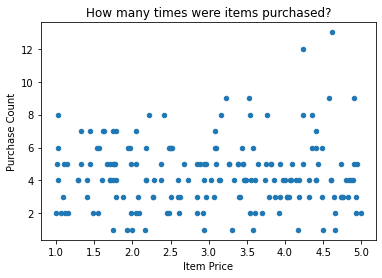

In [43]:
most_valuable_items.plot.scatter('Item Price', 'Purchase Count', title="How many times were items purchased?")

As we can see, except for a few standout performances, items performed more or less equally across the distribution of possible prices. So currently, higher priced items are on average likely to bring in a much higher revenue. 

This suggests to me a high end market that has not yet been fully tapped. It is possible that adding more high cost items, skewing the overall distribution of item price towards the top end, could result in higher revenues.